# Function Call Overhead

:label:`ch_call_overhead`


We are starting to benchmark various schedules since this chapter. Before diving into various running time numbers, we need to be aware of the overhead of issuing a function call in Python. It's well known that Python is not the fastest language on earth. Prototyping with Python is fast, but we also need to pay the cost that Python does smart things for us under the hook. In this section, we will investigate the overhead to call a function in Python, and demonstrate its impact to our later benchmarking results. 

In Python, we often use the `timeit` module to benchmark a workload, especially when its runtime is way less than 1 second. Note that Jupyter  has a magic build-in function `%timeit` that makes the usage simpler, but a function uses it cannot be saved for future usage, so we will use `timeit` directly.

In [1]:
import timeit
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

The following codes return the runtime of creating a `(4, 4)` zero matrix by 10 times.

In [2]:
timer = timeit.Timer(setup='import numpy as np',
                     stmt='np.zeros((4, 4))')
timer.timeit(10)

1.898303162306547e-05

We can see that the above workload can be done in tens of microsecond, we may need to increase the number of repeats to obtain relatively accurate runtime. 
The following function will determine the number of repeats needed to run about 1 second, and then return the average runtime.

In [3]:
# Save to the d2ltvm package.
def bench_workload(workload):
    """Benchmarka a workload
    
    workload - must accept a num_repeat argument and return the total runtime
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second.
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

print('time for np.zeros((4, 4)):', bench_workload(timer.timeit))

time for np.zeros((4, 4)): 2.6119269162400694e-07


## The Not Negligible Overhead

Now we benchmark the `copyto` method, which copies the contents of a ndarray to another one, on various size ndarrays.

In [4]:
def np_setup(n):
    return 'import numpy as np\n' \
           'x = np.random.normal(size=%d).astype("float32")\n' \
           'y = np.empty_like(x)\n'% n
        
def np_copy(n):
    return timeit.Timer(setup=np_setup(n),
                        stmt='np.copyto(y, x)')
    
sizes = 2**np.arange(5, 20, 4).astype('int')
np_times = [bench_workload(np_copy(n).timeit) for n in sizes]

Plot the throughput versus vector length.

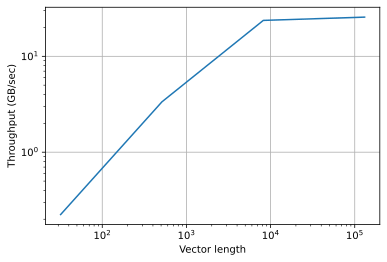

In [5]:
display.set_matplotlib_formats('svg')
plt.loglog(sizes, sizes*4/np_times/1e9)
plt.xlabel('Vector length')
plt.ylabel('Throughput (GB/sec)')
plt.grid()

We can see that the throughput increases and then becomes stable. It's not as expected. When the vector length is small, more likely we can fit it into cache, and therefore the throughput should be high. To examine the reason, let's simply draw the execution time versus vector length.

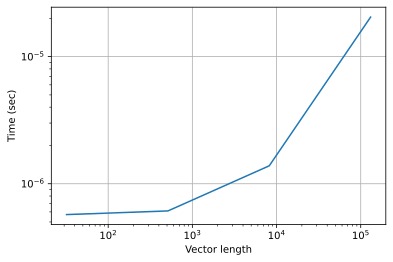

In [6]:
plt.loglog(sizes, np_times)
plt.xlabel('Vector length')
plt.ylabel('Time (sec)')
plt.grid()

We can see that when the vector length is smaller than $10^3$, the execution time is almost flat. It is dominated by the function call overhead. The overhead includes any argument preprocessing in the Python function, evoking the foreign function interface, and other [Python backend overhead](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/). Therefore, benchmarking too small workloads is not quite meaningful. 

## Overhead of NumPy, TVM and MXNet

During this book, we will benchmark various operators in Numpy, TVM and MXNet. Let's examine their function call overhead. We could roughly estimate it by executing some small workloads. Let first check NumPy.

In [7]:
sizes = 2**np.arange(1, 8).astype('int')
np_times = np.array([bench_workload(np_copy(n).timeit) for n in sizes])

print('NumPy call overhead: %.1f microsecond' % (np_times.mean()*1e6))

NumPy call overhead: 0.6 microsecond


The overhead of TVM is around 5x higher.

In [8]:
def tvm_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import tvm\n'
                        'x, y = tvm.nd.array(x), tvm.nd.array(y)',
                        stmt='x.copyto(y)')

tvm_times = np.array([bench_workload(tvm_copy(n).timeit) for n in sizes])
print('TVM call overhead: %.1f microsecond'% (tvm_times.mean()*1e6,))

TVM call overhead: 0.8 microsecond


MXNet has the highest overhead, it's even 8x times higher than TVM. The reason might due to MXNet uses `ctypes` while TVM is compiled with `cython`, and MXNet uses lazy evaluation that brings additional overhead.

In [9]:
def mx_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import mxnet as mx\n'
                        'x, y = mx.nd.array(x), mx.nd.array(y)\n'
                        'mx.nd.waitall()'% n,
                        stmt='x.copyto(y); y.wait_to_read()')

mx_times = np.array([bench_workload(mx_copy(n).timeit) for n in sizes])
print('MXNet call overhead: %.1f microsecond'% (mx_times.mean()*1e6,))

MXNet call overhead: 37.1 microsecond


## Summary

- The function call overhead might takes several microsecond. Benchmarking too small functions in Python is meaningless.